In [ ]:
import pandas as pd
import geopandas as gpd
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv
from torch_geometric.explain import Explainer, GNNExplainer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics.pairwise import haversine_distances
import torch.nn.functional as F


c:\Users\banan\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
CUDA = True  # or False depending on your preference
device = "cuda" if (torch.cuda.is_available() and CUDA) else "cpu"

In [8]:
node_df = pd.read_csv("data/node_features.csv")
road_gdf = gpd.read_file("data/singapore_road_network.gpkg" , layer="edges")

Graph Construction

In [15]:
node_df = node_df.drop(columns=[col for col in node_df.columns if "Unnamed" in col])
node_df = node_df.dropna()

coords = node_df[['Latitude', 'Longitude']].to_numpy()
coords_rad = np.radians(coords)
distances = haversine_distances(coords_rad) * 6371000  # in meters

# Define connectivity threshold (in meters)
edge_index = np.array(np.where((distances > 0) & (distances < 1000)))
edge_attr = distances[edge_index[0], edge_index[1]]

# Node features
node_df = node_df.rename(columns={
    'Total Casualties Fatalities': 'Total_Casualties_Fatalities',
    'Pedestrians': 'Pedestrians',
    'Rainfall_mm': 'Rainfall',
    'Traffic_Volume': 'Traffic_Volume'
})

# Pick the clean features we can use
feature_cols = [
    'Rainfall',
    'Traffic_Volume',
    'Total_Casualties_Fatalities',
    'Pedestrians'
]
node_df.columns = node_df.columns.str.strip()
features = node_df[feature_cols].astype(float).to_numpy()
scaler = StandardScaler()
x = torch.tensor(scaler.fit_transform(features), dtype=torch.float)

# Binary labels: hotspot or not
threshold = node_df['Total_Casualties_Fatalities'].astype(float).median()
y = torch.tensor((node_df['Total_Casualties_Fatalities'].astype(float) > threshold).astype(int).values, dtype=torch.long)

data = Data(
    x=x,
    edge_index=torch.tensor(edge_index, dtype=torch.long),
    edge_attr=torch.tensor(edge_attr, dtype=torch.float),
    y=y
)

In [16]:
print(node_df.columns.tolist())


['Latitude', 'Longitude', 'Date', 'Rainfall', 'Traffic_Volume', 'Total_Casualties_Fatalities', 'Pedestrians', 'Personal Mobility Device Users', 'Cyclists & Pillions', 'Motor Cyclists & Pillion Riders', 'Motor Cars And Station Wagons', 'Goods Vans & Pick-Ups', 'Goods Vans', 'Pick-Ups', 'Lorries, Tipper Trucks & Trailers', 'Lorries', 'Tipper Trucks', 'Trailers', 'Buses', 'Others', 'Total Casualties Injured', 'Pedestrians.1', 'Personal Mobility Device Users.1', 'Cyclists & Pillions.1', 'Motor Cyclists & Pillion Riders.1', 'Motor Cars And Station Wagons.1', 'Goods Vans & Pick-Ups.1', 'Goods Vans.1', 'Pick-Ups.1', 'Lorries, Tipper Trucks & Trailers.1', 'Lorries.1', 'Tipper Trucks.1', 'Trailers.1', 'Buses.1', 'Others.1', 'Total Casualties Fatalities_casualty', 'Pedestrians_casualty', 'Personal Mobility Device Users_casualty', 'Cyclists & Pillions_casualty', 'Motor Cyclists & Pillion Riders_casualty', 'Motor Cars And Station Wagons_casualty', 'Goods Vans & Pick-Ups_casualty', 'Goods Vans_casu

Train Test Validation Split

In [17]:
indices = np.arange(data.num_nodes)
train_idx, temp_idx = train_test_split(indices, test_size=0.4, random_state=42, stratify=y)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=42, stratify=y[temp_idx])

data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.train_mask[train_idx] = True
data.val_mask[val_idx] = True
data.test_mask[test_idx] = True


Define GAT Model

In [20]:
class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=2):
        super().__init__()
        self.gat1 = GATConv(in_channels, hidden_channels, heads=heads)
        self.gat2 = GATConv(hidden_channels * heads, out_channels, heads=1)

    def forward(self, x, edge_index):
        x = F.elu(self.gat1(x, edge_index))
        x = self.gat2(x, edge_index)
        return x

model = GAT(in_channels=x.size(1), hidden_channels=16, out_channels=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
loss_fn = torch.nn.CrossEntropyLoss()


Trainer function

In [ ]:


train_losses, val_accuracies = [], []

for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    model.eval()
    val_pred = out[data.val_mask].argmax(dim=1)
    val_acc = accuracy_score(data.y[data.val_mask].cpu(), val_pred.cpu())

    train_losses.append(loss.item())
    val_accuracies.append(val_acc)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}, Val Acc: {val_acc:.4f}")


Epoch 0, Loss: 0.7308, Val Acc: 0.3182
Epoch 10, Loss: 0.4459, Val Acc: 0.7273
Epoch 20, Loss: 0.3677, Val Acc: 0.6818
Epoch 30, Loss: 0.3474, Val Acc: 0.8182
Epoch 40, Loss: 0.3301, Val Acc: 0.8182
Epoch 50, Loss: 0.3156, Val Acc: 0.8636
Epoch 60, Loss: 0.3050, Val Acc: 0.8636
Epoch 70, Loss: 0.2933, Val Acc: 0.9091
Epoch 80, Loss: 0.2816, Val Acc: 0.9545
Epoch 90, Loss: 0.2694, Val Acc: 0.9091


Evaluation on test set

Test Accuracy: 0.8636


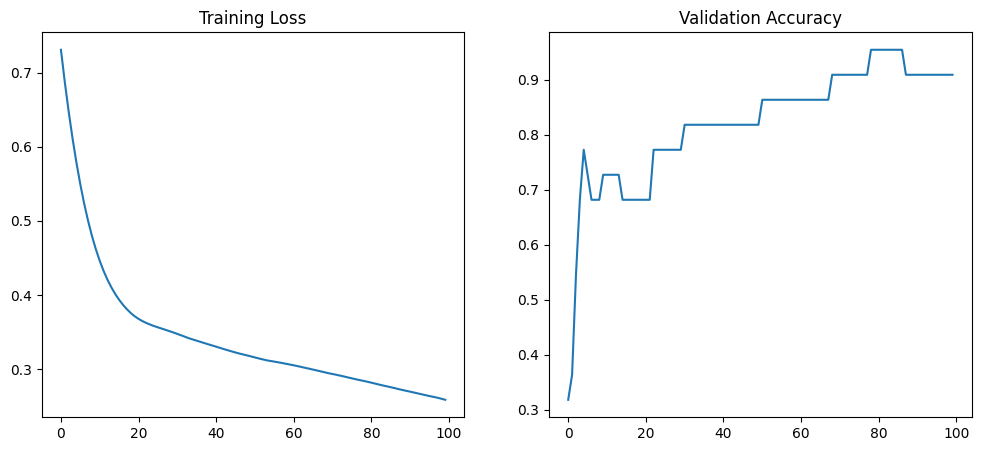

In [23]:
model.eval()
out = model(data.x, data.edge_index)
pred = out.argmax(dim=1)

test_acc = accuracy_score(data.y[data.test_mask].cpu(), pred[data.test_mask].cpu())
print(f"Test Accuracy: {test_acc:.4f}")

## 7. Plot Loss & Accuracy
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses)
plt.title("Training Loss")

plt.subplot(1,2,2)
plt.plot(val_accuracies)
plt.title("Validation Accuracy")
plt.show()

Output

In [31]:
from torch_geometric.explain.config import ModelReturnType
print(list(ModelReturnType))


[<ModelReturnType.raw: 'raw'>, <ModelReturnType.probs: 'probs'>, <ModelReturnType.log_probs: 'log_probs'>]


In [32]:
from torch_geometric.explain import Explainer, GNNExplainer
from torch_geometric.explain.config import ModelConfig, ModelMode, ModelTaskLevel, ModelReturnType

explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type="model",
    node_mask_type="attributes",
    edge_mask_type="object",
    model_config=ModelConfig(
        mode=ModelMode.multiclass_classification,      # ✅ use Enum
        task_level=ModelTaskLevel.node,     # ✅ use Enum
        return_type=ModelReturnType.raw  # ✅ use Enum
    )
)



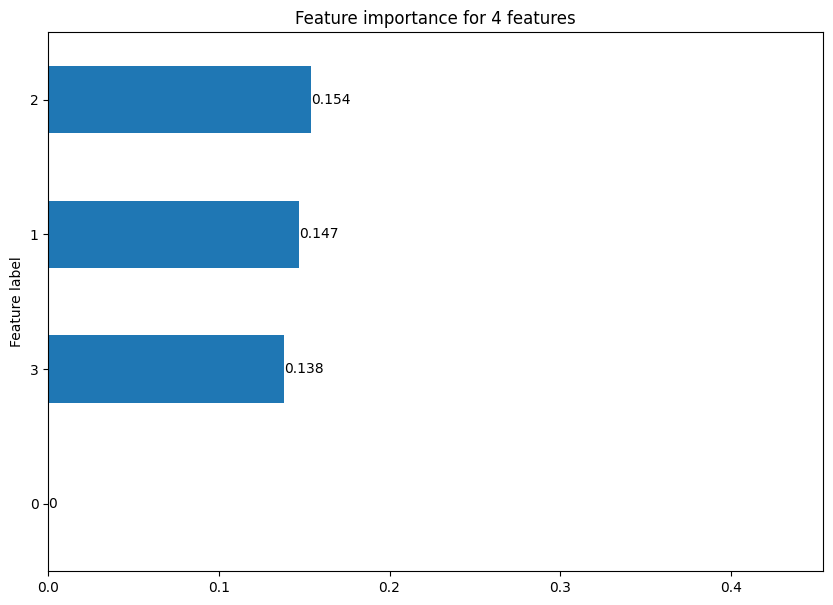

In [33]:
node_idx = int(val_idx[0])
explanation = explainer(data.x, data.edge_index, index=node_idx)
explanation.visualize_feature_importance()


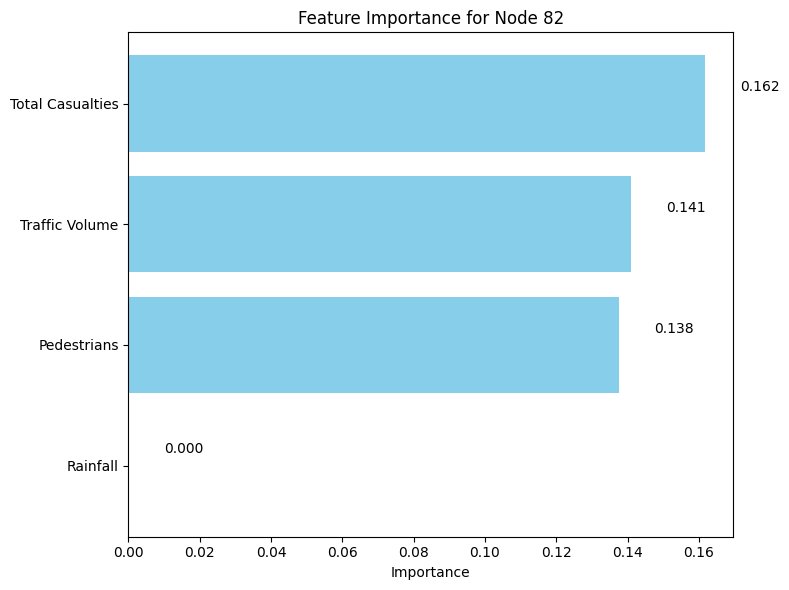

In [48]:
# 1. Pick node and explain
node_idx = int(val_idx[0])
explanation = explainer(x=data.x, edge_index=data.edge_index, index=node_idx)

# 2. Get the global flat mask
importance = explanation.node_mask.detach().cpu().numpy().flatten()

# 3. Extract only the part for the current node
num_features = 4
start = node_idx * num_features
end = start + num_features
importance = importance[start:end]  # ✅ extract feature importance for the node

# 4. Plotting
feature_labels = ['Rainfall', 'Traffic Volume', 'Total Casualties', 'Pedestrians']
indices = np.argsort(importance)[::-1]
sorted_importance = importance[indices]
sorted_labels = [feature_labels[int(i)] for i in indices]

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
bars = plt.barh(range(len(sorted_labels)), sorted_importance, color='skyblue')
plt.yticks(range(len(sorted_labels)), sorted_labels)
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title(f"Feature Importance for Node {node_idx}")
for i, bar in enumerate(bars):
    plt.text(bar.get_width() + 0.01, bar.get_y() + 0.3, f"{sorted_importance[i]:.3f}")
plt.tight_layout()
plt.show()


In [45]:
print("importance shape:", importance.shape)
print("importance:", importance)

indices = np.argsort(importance)[::-1]
print("sorted indices:", indices)


importance shape: (432,)
importance: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.     